<a href="https://colab.research.google.com/github/annasajkh/VQGAN-CLIP-naive_implementation-/blob/main/VQGAN%2BCLIP_(naive_implementation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install rudalle

import torch
import clip
from torch.optim import AdamW
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from rudalle import get_vae


normalize_clip = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

augmentation = nn.Sequential(
  transforms.RandomHorizontalFlip(0.5),
  transforms.RandomAffine(degrees=30, translate=(0.0, 0.3)),
  transforms.RandomCrop(size=(224, 224))
)

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _ = clip.load("ViT-B/32", device=device)

In [26]:
text = "fire and water dancing #art #digitalart 4k wallpaper trending on artstation"

lr_init = 3e-4

steps = 1000

weight_decay = 0.5
 
image_augmentation_count = 4

show_interval = 50

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


  0%|          | 0/1000 [00:00<?, ?it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 5.94140625


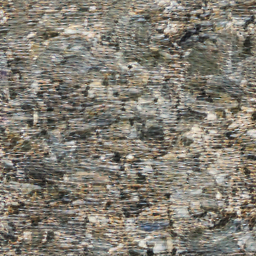

  5%|▌         | 50/1000 [00:15<04:53,  3.24it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 2.28515625


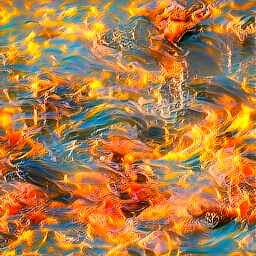

 10%|█         | 100/1000 [00:31<04:40,  3.21it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 2.015625


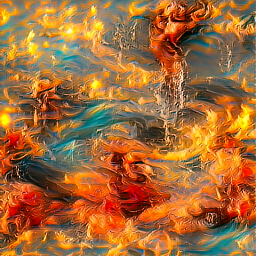

 15%|█▌        | 150/1000 [00:46<04:21,  3.25it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 1.8466796875


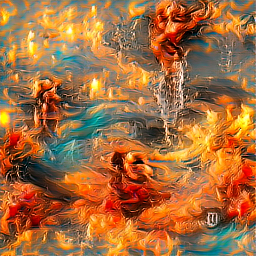

 20%|██        | 200/1000 [01:02<04:04,  3.28it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 1.80078125


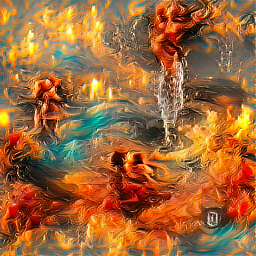

 25%|██▌       | 250/1000 [01:17<03:51,  3.23it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 1.751953125


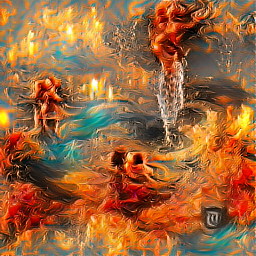

 30%|███       | 300/1000 [01:32<03:35,  3.25it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 1.7470703125


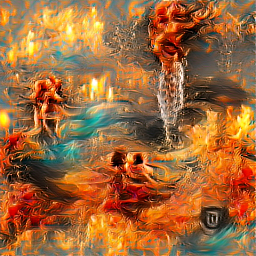

 35%|███▌      | 350/1000 [01:48<03:20,  3.24it/s]


fire and water dancing #art #digitalart 4k wallpaper trending on artstation
Loss: 1.6923828125


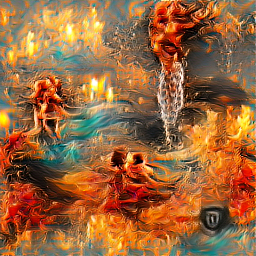

 36%|███▌      | 360/1000 [01:51<03:18,  3.22it/s]


KeyboardInterrupt: ignored

In [27]:
vae = get_vae().to(device)

text_tokenized = clip.tokenize([text]).to(device)

rand_latent = torch.randint(low=0, high=8192, size=(1, 1024)).to(device).long()
optimizer = AdamW(vae.parameters(), lr=lr_init, weight_decay=weight_decay)

for i in tqdm(range(steps)):
    y = vae.decode(rand_latent)
    img = normalize_clip(y)
    
    image = F.interpolate(img, (224, 224))

    images = torch.zeros(image_augmentation_count, 3, 224, 224).to(device)
    
    for j in range(image_augmentation_count - 1):
        images[j] = augmentation(image)
    
    images[-1] = image
    
    texts = torch.repeat_interleave(text_tokenized, image_augmentation_count, dim=0)
    
    loss = 1 / clip_model(images, texts)[0].mean() * 100
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % show_interval == 0:
        print("\n" + text)
        print("Loss: " + str(loss.item()))
        
        with torch.no_grad():
            generated = (y.permute(0, 2, 3, 1) * 255).to(torch.uint8)
            display(Image.fromarray(generated[0].cpu().numpy(), "RGB"))
    
    

print(text)
print("Loss: " + str(loss.item()))

with torch.no_grad():
    generated = (y.permute(0, 2, 3, 1) * 255).to(torch.uint8)
    display(Image.fromarray(generated[0].cpu().numpy(), "RGB"))